# Comparison of MS partitions and NUTS at baseline

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

In [5]:
plt.rcParams.update({'font.size': 20})

In [81]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import compute_indicator_matrix, flow_coverage, flow_coverage_community, compute_containment
from utils import R2_score

root_figure = path+"/figures/"
root_map = path+'/data/geo_shapefiles/Local_Authority_Districts__May_2020__Boundaries_UK_BGC-shp/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.shp'
root_baseline_data = path+'/data/fb_movement_maps/BETWEEN_TILES_BASELINE.csv'
root_processed = path+"/data/processed/"
root_networks = path+"/data/processed/networks/"
root_results = path+"/results/"

## Import baseline network and partitions

In [7]:
#################
# Load datasets #
#################

# Load LSCC
root_lscc = root_networks+'/base_network_lscc.npz'
with open(root_lscc, 'rb') as handle:
        lscc_dict = pickle.load(handle)
        
##############################
# Generate DiGraph from data #
##############################

lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)
lscc_nodes = list(lscc.nodes())
n_nodes = len(lscc_nodes)

# Store node numbers
node_numbers = {i : lscc_nodes[i] for i in range(n_nodes)}

# Load geom_dict
root_geom_dict = root_networks+'/base_geom_dict.pickle'
with open(root_geom_dict, 'rb') as handle:
        geom_dict = pickle.load(handle)
# Gemo dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
A_LSCC_array = A_LSCC.toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

In [8]:
# Load data (deserialize)
with open(root_results+'MS_results.pkl', 'rb') as handle:
    all_results = pickle.load(handle)


In [12]:
# Load NUTS3 data
root_NUTS3 = root_processed+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}

# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[list(lscc.nodes())[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

Shape of NUTS3 data: (5436, 180)
The max is obtained in average with: 0.93
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


In [13]:
NUTS_partitions = []
node_keys = list(lscc.nodes())

for labels in [NUTS3_id,NUTS2_id,NUTS1_id]:
    k = len(set(labels))
    partition = []
    for i in set(labels):
        c = np.argwhere(labels == i).flatten()
        c_set = set(node_keys[j] for j in c)
        partition.append(c_set)
    NUTS_partitions.append(partition)

NUTS_partitions = np.asarray(NUTS_partitions)

/tmp/ipykernel_75579/2554380281.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  NUTS_partitions = np.asarray(NUTS_partitions)


In [14]:
NUTS_partitions = []

for node_id in [NUTS3_id,NUTS2_id,NUTS1_id]:
    H = compute_indicator_matrix(node_id)
    # delete empty columns
    H = H[:, np.sum(H, axis=0) > 0]
    NUTS_partitions.append(H)

In [15]:
# statistics for NUTS
partition_names = []
rank_partitions = []
max_c = []
Q1_c = []
Q2_c = []
Q3_c = []
min_c = []

for i in range(3):

    level = "NUTS {}".format(i+1)
    partition_names.append(level)
    partition = NUTS_partitions[i]
    n_communities = np.linalg.matrix_rank(partition)
    rank_partitions.append(n_communities)
    community_sizes = np.sum(partition, axis=0)
    max_c.append(int(np.max(community_sizes)))
    Q1_c.append(int(np.percentile(community_sizes, q =25)))
    Q2_c.append(int(np.percentile(community_sizes, q =50)))
    Q3_c.append(int(np.percentile(community_sizes, q =75)))
    min_c.append(int(np.min(community_sizes)))
    
community_stats = pd.DataFrame({'Level' : partition_names, 'n_communities' : rank_partitions, 'min_size' : min_c,
                                'Q1':Q1_c, 'Q2' : Q2_c, 'Q3' : Q3_c, 'max_size' : max_c})

In [16]:
partition = NUTS_partitions[0]

In [17]:
community_stats

,Level,n_communities,min_size,Q1,Q2,Q3,max_size
0,NUTS 1,170,1,4,13,27,102
1,NUTS 2,42,1,40,72,102,238
2,NUTS 3,12,44,230,254,324,422


## Comparison via NVI

In [21]:
# Get times
times = all_results['times']
min_time = all_results['run_params']['min_time']
max_time = all_results['run_params']['max_time']
n_time = all_results['run_params']['n_time']
log_times = np.linspace(min_time,max_time,n_time)

# Get information about communities
community_id = np.asarray(all_results['community_id'])
n_communities  = np.asarray(all_results['number_of_communities'])
n_times = len(n_communities)

In [24]:
community_id_ranked = community_id.copy()

for time in range(n_times):
    # Compute sizes of each community
    labels_graph_counts = np.histogram(community_id[time],bins=np.arange(0,n_communities[time]+1)) [0]
    # Get class indices sorted according to size
    community_ranked = np.argsort(-labels_graph_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {community_ranked[k] : k for k in range(0,n_communities[time])}
    # Apply permutation to labels
    labels_community = community_id[time].copy()
    for i in range (0,len(labels_community)):
        labels_community[i] = rank[labels_community[i]]
    
    community_id_ranked[time] = labels_community

In [29]:
from sklearn import metrics

In [30]:
def entropy(labels):
    """Calculates the entropy for a labeling.
    Parameters
    ----------
    labels : int array, shape = [n_samples]
        The labels
    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))

def variation_of_information(x,y, normalised = True):
    Ex = entropy(x)
    Ey = entropy(y)
    I = metrics.mutual_info_score(x,y)
    
    if normalised:
        return  (Ex + Ey - 2*I) / (Ex + Ey - I)
    else: 
        return Ex + Ey - 2*I

In [31]:
nvi_NUTS1 = []
nvi_NUTS2 = []
nvi_NUTS3 = []


for time in range(n_time):
    nvi_NUTS1.append(variation_of_information(community_id_ranked[time],NUTS1_id))
    nvi_NUTS2.append(variation_of_information(community_id_ranked[time],NUTS2_id))
    nvi_NUTS3.append(variation_of_information(community_id_ranked[time],NUTS3_id))

nvi_NUTS1 = np.asarray(nvi_NUTS1)
nvi_NUTS2 = np.asarray(nvi_NUTS2)
nvi_NUTS3 = np.asarray(nvi_NUTS3)

In [32]:
# Compute optimal times for NVI
nvi_t_NUTS1 = log_times[np.argmin(nvi_NUTS1)]
nvi_NUTS1_min = np.min(nvi_NUTS1)
print('Optimal Markov time for NUTS1:', np.around(nvi_t_NUTS1,2), 'with NVI', 
      np.around(nvi_NUTS1_min,2))
nvi_t_NUTS2 = log_times[np.argmin(nvi_NUTS2)]
nvi_NUTS2_min = np.min(nvi_NUTS2)
print('Optimal Markov time for NUTS2:', np.around(nvi_t_NUTS2,2), 'with NVI', 
      np.around(nvi_NUTS2_min,2))
nvi_t_NUTS3 = log_times[np.argmin(nvi_NUTS3)]
nvi_NUTS3_min = np.min(nvi_NUTS3)
print('Optimal Markov time for NUTS3:', np.around(nvi_t_NUTS3,2), 'with NVI', 
      np.around(nvi_NUTS3_min,2))

Optimal Markov time for NUTS1: 0.88 with NVI 0.41
Optimal Markov time for NUTS2: -0.34 with NVI 0.33
Optimal Markov time for NUTS3: -1.63 with NVI 0.27


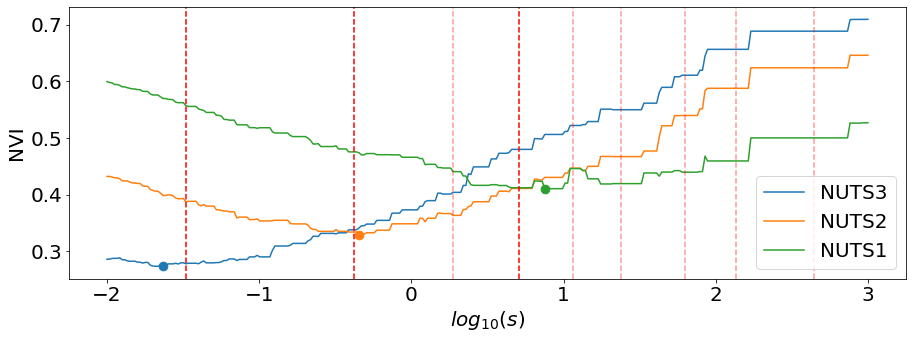

In [34]:
robust_scales = all_results["selected_partitions"]

# Plot
fig, ax = plt.subplots(1,figsize =(15,5))

ax.plot(log_times,nvi_NUTS3, label = 'NUTS3')
ax.plot(log_times,nvi_NUTS2, label = 'NUTS2')
ax.plot(log_times,nvi_NUTS1, label = 'NUTS1')

ax.scatter(nvi_t_NUTS3,nvi_NUTS3_min,marker='.',s=300)
ax.scatter(nvi_t_NUTS2,nvi_NUTS2_min,marker='.',s=300)
ax.scatter(nvi_t_NUTS1,nvi_NUTS1_min,marker='.',s=300)

for i in robust_scales:
    if i in [robust_scales[0],robust_scales[1],robust_scales[3]]:
        ax.axvline(x = log_times[i], ls="--", color = 'red')
    else:
        ax.axvline(x = log_times[i], ls="--", color = 'red', alpha = 0.4)



ax.set(xlabel = r"$log_{10}(s)$",ylabel = 'NVI') #,sitle='Similarity between Markov Stability partitions and NUTS regions')
        #yticks = [0.3,0.5,0.7] ) 
ax.legend(loc=4)
plt.show()

fig.savefig(root_figure +'MS_NUTS_matching.pdf', dpi=fig.dpi,bbox_inches='tight')

In [55]:
# select the three MS partitions most similar to NUTS
MS0_id = np.asarray(all_results['community_id'][robust_scales[0]])
MS1_id = np.asarray(all_results['community_id'][robust_scales[1]])
MS3_id = np.asarray(all_results['community_id'][robust_scales[3]])

MS_partitions = []

for node_id in [MS0_id,MS1_id,MS3_id]:
    H = compute_indicator_matrix(node_id)
    MS_partitions.append(H)

## Comparison of flow coverage of partitions

In [56]:
TFC_NUTS = 100*np.array([flow_coverage(lscc,NUTS_partitions[0]),flow_coverage(lscc,NUTS_partitions[1]),flow_coverage(lscc,NUTS_partitions[2])])
TFC_MS = 100*np.array([flow_coverage(lscc,MS_partitions[0]),flow_coverage(lscc,MS_partitions[1]),flow_coverage(lscc,MS_partitions[2])])

In [57]:
np.around(TFC_NUTS,1)

array([90.1, 95.2, 98.9])

In [58]:
np.around(TFC_MS,1)

array([92.1, 98.4, 99.7])

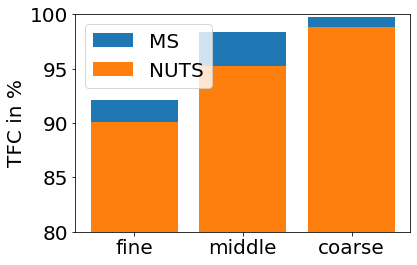

In [59]:
fig, ax = plt.subplots(1)
ax.bar(range(3),TFC_MS,label='MS')
ax.bar(range(3),TFC_NUTS,label='NUTS')
ax.set(xticks=range(3),xticklabels=['fine','middle','coarse'],ylim=(80,100),ylabel='TFC in %')
ax.legend()
plt.show()

## Comparison of flow coverage on community level

In [60]:
# Compute TFC on community level
TFC_NUTS3 = flow_coverage_community(lscc,NUTS_partitions[0])
TFC_NUTS2 = flow_coverage_community(lscc,NUTS_partitions[1])
TFC_NUTS1 = flow_coverage_community(lscc,NUTS_partitions[2])
TFC_MS0 = flow_coverage_community(lscc,MS_partitions[0])
TFC_MS1 = flow_coverage_community(lscc,MS_partitions[1])
TFC_MS3 = flow_coverage_community(lscc,MS_partitions[2])

In [61]:
# # Remove nan values
# TFC_NUTS3 = TFC_NUTS3[~np.isnan(TFC_NUTS3)]
# TFC_NUTS2 = TFC_NUTS2[~np.isnan(TFC_NUTS2)]
# TFC_NUTS1 = TFC_NUTS1[~np.isnan(TFC_NUTS1)]

In [62]:
tfcs = [TFC_NUTS3,TFC_NUTS2,TFC_NUTS1,TFC_MS0,TFC_MS1,TFC_MS3]
names = ['TFC_NUTS3','TFC_NUTS2','TFC_NUTS1','TFC_MS0','TFC_MS1','TFC_MS3']

for i in range(6):
    tfc=tfcs[i]
    if i == 0:
        print('TFC & NUTS')
    if i == 3:
        print('TFC & MS')
    print('& $', np.around(tfc.mean(),3),'\mp',np.around(tfc.std(),3),'$')


TFC & NUTS
& $ 0.908 \mp 0.073 $
& $ 0.953 \mp 0.072 $
& $ 0.991 \mp 0.01 $
TFC & MS
& $ 0.933 \mp 0.083 $
& $ 0.989 \mp 0.014 $
& $ 0.997 \mp 0.003 $


## Comparison with Nodel Containment - table

In [63]:
# Compute Containment
Cont_NUTS3 = compute_containment(lscc,NUTS3_id)
Cont_NUTS2 = compute_containment(lscc,NUTS2_id)
Cont_NUTS1 = compute_containment(lscc,NUTS1_id)
Cont_MS0 = compute_containment(lscc,MS0_id)
Cont_MS1 = compute_containment(lscc,MS1_id)
Cont_MS3 = compute_containment(lscc,MS3_id)

In [64]:
containments = [Cont_NUTS3,Cont_NUTS2,Cont_NUTS1,Cont_MS0,Cont_MS1,Cont_MS3]

for i in range(6):
    cont=containments[i]
    if i == 0:
        print('NC & NUTS')
    if i == 3:
        print('NC & MS')
    print('& $', np.around(cont.mean(),3),'\mp',np.around(cont.std(),3),'$')


NC & NUTS
& $ 0.729 \mp 0.314 $
& $ 0.883 \mp 0.233 $
& $ 0.958 \mp 0.145 $
NC & MS
& $ 0.866 \mp 0.196 $
& $ 0.955 \mp 0.103 $
& $ 0.981 \mp 0.075 $


## Summary Box Plots for Coverage and Nodal Containment

In [66]:
TFC = pd.DataFrame.from_dict({'NUTS3' : TFC_NUTS3,'MS0':TFC_MS0,'NUTS2' : TFC_NUTS2,'MS1':TFC_MS1,'NUTS1' : TFC_NUTS1,'MS3':TFC_MS3,}, orient='index')
TFC = TFC.transpose()

NC = pd.DataFrame.from_dict({'NUTS3' : Cont_NUTS3,'MS0':Cont_MS0,'NUTS2' : Cont_NUTS2,'MS1':Cont_MS1,'NUTS1' : Cont_NUTS1,'MS3':Cont_MS3,}, orient='index')
NC = NC.transpose()

In [68]:
from matplotlib.patches import Patch

/tmp/ipykernel_75579/2612829540.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax1.boxplot(np.asarray([TFC_NUTS3,TFC_NUTS2,TFC_NUTS1]),positions=x-offset,notch=False,boxprops=dict(facecolor='tab:blue'),showfliers=False, showmeans=False,**box_param)
/tmp/ipykernel_75579/2612829540.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax1.boxplot(np.asarray([TFC_MS0,TFC_MS1,TFC_MS3]),positions=x+offset,notch=False,boxprops=dict(facecolor='tab:orange'),showfliers=False, showmeans=False,**box_param)


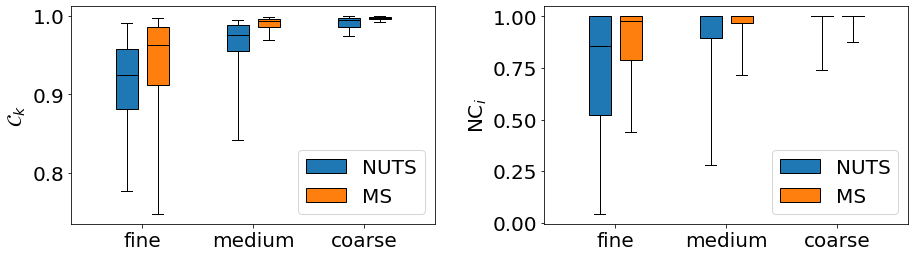

In [70]:
fig = plt.figure(figsize=(15,4))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = np.arange(3)
offset=0.14
xticklabels = ['fine','medium','coarse']

legend_elements = [Patch(facecolor='tab:blue', edgecolor='black',label='NUTS'),Patch(facecolor='tab:orange', edgecolor='black',label='MS')]


box_param = dict(whis=(5, 95), widths=0.2, patch_artist=True,
                 flierprops=dict(marker='.', markeredgecolor='black',
                 fillstyle=None), medianprops=dict(color='black'),
                 meanprops=dict(marker='.',ms=15,mfc='red', markeredgecolor='black',
                 fillstyle=None))

ax1.boxplot(np.asarray([TFC_NUTS3,TFC_NUTS2,TFC_NUTS1]),positions=x-offset,notch=False,boxprops=dict(facecolor='tab:blue'),showfliers=False, showmeans=False,**box_param)
ax1.boxplot(np.asarray([TFC_MS0,TFC_MS1,TFC_MS3]),positions=x+offset,notch=False,boxprops=dict(facecolor='tab:orange'),showfliers=False, showmeans=False,**box_param)
ax1.set(xticks=x,xticklabels=xticklabels,ylabel=r'$\mathcal{C}_k$')
ax1.legend(handles=legend_elements)

ax2.boxplot(np.asarray([Cont_NUTS3,Cont_NUTS2,Cont_NUTS1]).transpose(),positions=x-offset,notch=False,boxprops=dict(facecolor='tab:blue'),showfliers=False, showmeans=False, **box_param)
ax2.boxplot(np.asarray([Cont_MS0,Cont_MS1,Cont_MS3]).transpose(),positions=x+offset,notch=False,boxprops=dict(facecolor='tab:orange'),showfliers=False,showmeans=False, **box_param)
ax2.set(xticks=x,xticklabels=xticklabels,ylabel=r'NC$_i$')
ax2.legend(handles=legend_elements)

plt.show()

##path'/home/tc/OneDrive/Research Projects/Multiscale mobility patterns and the restriction of human mobility under lockdown/Figures/Figure 4/'

fig.savefig(root_figure+'comparison_boxplots_coverage_NC.pdf', dpi=fig.dpi,bbox_inches='tight')

## Statistical tests

In [71]:
# apply Mann-Whitney U test
from scipy.stats import mannwhitneyu

print('Fine - NUTS3/MS0')
U, p_f_tfc = mannwhitneyu(TFC_NUTS3,TFC_MS0)
print('TFC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_tfc, p_f_tfc<0.0001)
U, p_f_nc = mannwhitneyu(Cont_NUTS3,Cont_MS0)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_nc, p_f_nc<0.0001)


print('\nMedium - NUTS2/MS1')
U, p_m_tfc = mannwhitneyu(TFC_NUTS2,TFC_MS1)
print('TFC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_m_tfc, p_m_tfc<0.0001)
U, p_m_nc = mannwhitneyu(Cont_NUTS2,Cont_MS1)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_m_nc, p_m_nc<0.0001)

print('\nCoarse - NUTS1/MS3')
U, p_c_tfc = mannwhitneyu(TFC_NUTS1,TFC_MS3)
print('TFC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_c_tfc, p_c_tfc<0.0001 )
U, p_c_nc = mannwhitneyu(Cont_NUTS1,Cont_MS3)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_c_nc, p_c_nc<0.0001)

Fine - NUTS3/MS0
TFC: Mann-Whitney U test rejects null hypothesis with p-value:  1.9555358712329842e-07 True
NC: Mann-Whitney U test rejects null hypothesis with p-value:  6.044712058189661e-54 True

Medium - NUTS2/MS1
TFC: Mann-Whitney U test rejects null hypothesis with p-value:  3.119699311248298e-07 True
NC: Mann-Whitney U test rejects null hypothesis with p-value:  1.1754134204188366e-16 True

Coarse - NUTS1/MS3
TFC: Mann-Whitney U test rejects null hypothesis with p-value:  0.061682841920716505 False
NC: Mann-Whitney U test rejects null hypothesis with p-value:  0.00024452779026533475 False


## Nodal containment - histograms

In [72]:
# Compute nodal differences of containment for MS0 vs NUTS3, MS1 vs NUTS2 and MS3 vs NUTS1
diff_fine = (compute_containment(lscc,MS0_id)-compute_containment(lscc,NUTS3_id))
diff_middle = (compute_containment(lscc,MS1_id)-compute_containment(lscc,NUTS2_id))
diff_coarse = (compute_containment(lscc,MS3_id)-compute_containment(lscc,NUTS1_id))

In [73]:
print('Differences of containment for MS0 vs NUTS3:')
print('Mean: ',np.around(diff_fine.mean(),3))
print('Std: ',np.around(diff_fine.std(),3))
print('\n')
print('Differences of containment for MS1 vs NUTS2:')
print('Mean: ',np.around(diff_middle.mean(),3))
print('Std: ',np.around(diff_middle.std(),3))
print('\n')
print('Differences of containment for MS3 vs NUTS1:')
print('Mean: ',np.around(diff_coarse.mean(),3))
print('Std: ',np.around(diff_coarse.std(),3))

Differences of containment for MS0 vs NUTS3:
Mean:  0.138
Std:  0.298


Differences of containment for MS1 vs NUTS2:
Mean:  0.072
Std:  0.228


Differences of containment for MS3 vs NUTS1:
Mean:  0.023
Std:  0.157


In [74]:
import matplotlib as mpl

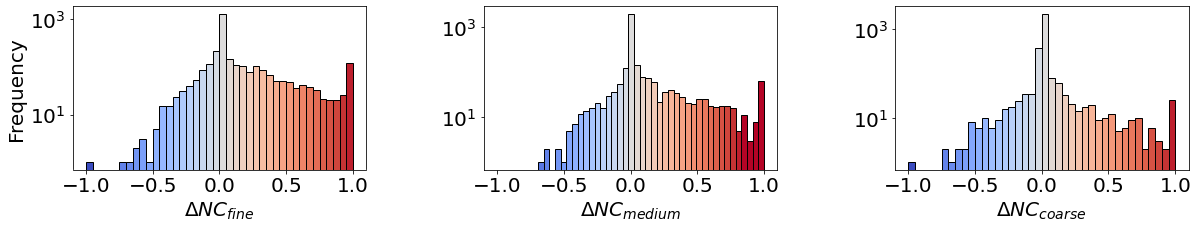

In [75]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.4)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

n_bins = 40
cm = plt.cm.coolwarm

n, bins, patches = ax1.hist(diff_fine, bins=n_bins, edgecolor='black')
ax1.set(xticks=[-1,-0.5,0,0.5,1],ylabel='Frequency',xlabel=r'$\Delta NC_{fine}$',yscale='log',xlim=(-1.1,1.1))
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/n_bins))

n, bins, patches = ax2.hist(diff_middle, bins=n_bins, edgecolor='black')
ax2.set(xticks=[-1,-0.5,0,0.5,1],#ylabel='Frequency',
xlabel=r'$\Delta NC_{medium}$',yscale='log',xlim=(-1.1,1.1))
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm((i+4)/n_bins))

n, bins, patches = ax3.hist(diff_coarse, bins=n_bins, edgecolor='black')
ax3.set(xticks=[-1,-0.5,0,0.5,1],#ylabel='Frequency',
xlabel=r'$\Delta NC_{coarse}$',yscale='log',xlim=(-1.1,1.1))
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/n_bins))


plt.show()

#path'/home/tc/OneDrive/Research Projects/Multiscale mobility patterns and the restriction of human mobility under lockdown/Figures/Figure 5/'

fig.savefig(root_figure+'containment_hist.pdf', dpi=fig.dpi,bbox_inches='tight')



## Nodal Containment - maps

In [76]:
import geopandas as gpd
import mercantile
from shapely.geometry import shape

In [78]:
#######################
# Load map shape file #
#######################

map_df = gpd.read_file(root_map)
map_df['DUMMY'] = 1
# Dissovle to one shape
map_df2 = map_df.dissolve(by='DUMMY')
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.facecolor'] = 'b'
map_df = map_df.to_crs("EPSG:3395")
map_df2 = map_df2.to_crs("EPSG:3395")

In [79]:
# Get quadkeys from lscc
quadkeys = list(lscc.nodes())
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

In [80]:
gdf['diff_fine']=diff_fine
gdf['diff_middle']=diff_middle
gdf['diff_coarse']=diff_coarse

In [82]:
# Import NUTS shape files
root_map = path+'/data/geo_shapefiles/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# remove Scotish islands
map_gdf=map_gdf[~map_gdf['nuts318cd'].isin(['UKM65', 'UKM66'])]
map_gdf.reset_index(drop=True,inplace=True)

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

gdf_NUTS3['DUMMY'] = 1
gdf_bndr = gdf_NUTS3.dissolve(by = 'DUMMY')


# Get NUTS2
gdf_NUTS2 = gdf_NUTS3.copy()
gdf_NUTS2['nuts'] = [gdf_NUTS2['nuts'][i][:4] for i in range((len(gdf_NUTS3)))]
gdf_NUTS2 = gdf_NUTS2.dissolve(by='nuts')

# Get NUTS1
gdf_NUTS1 = gdf_NUTS3.copy()
gdf_NUTS1['nuts'] = [gdf_NUTS1['nuts'][i][:3] for i in range(len(gdf_NUTS3))]
gdf_NUTS1 = gdf_NUTS1.dissolve(by='nuts')

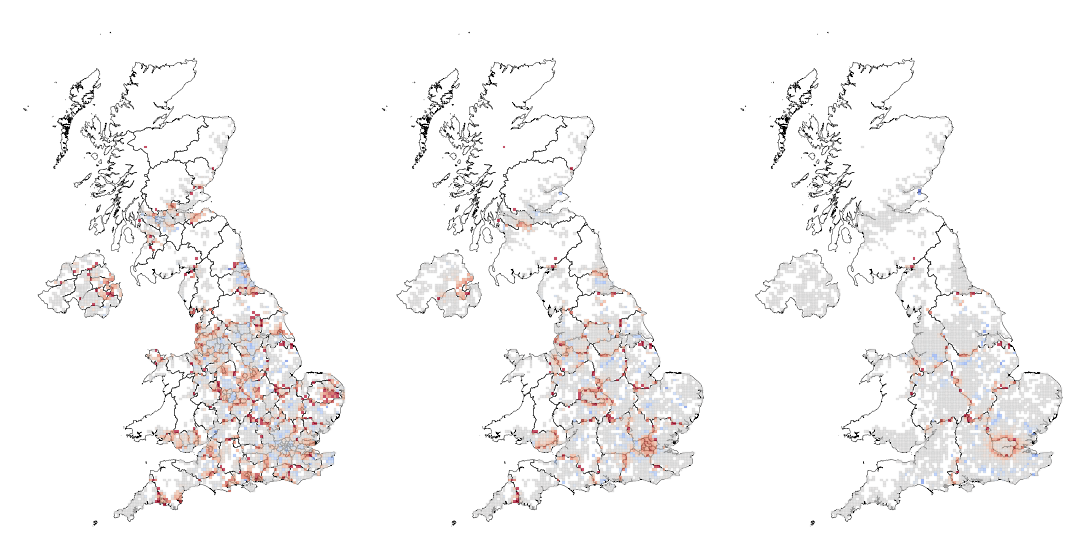

In [83]:
# Plot all quadkeys
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=-0.1)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

tile_width = 0.1
map_width = 0.4
tile_alpha = 0.7

gdf_NUTS3.plot(linewidth=map_width, ax=ax1, facecolor = 'none')
gdf.plot('diff_fine',alpha = tile_alpha, linewidth = tile_width,ax=ax1, cmap='coolwarm',vmin=-1,vmax=1,edgecolor='grey')
ax1.set_axis_off()
#ax1.set(title='MS0 vs. NUTS3')

gdf_NUTS2.plot(linewidth=map_width, ax=ax2, facecolor = 'none')
gdf.plot('diff_middle',alpha = tile_alpha, linewidth = tile_width,ax=ax2, cmap='coolwarm',vmin=-1,vmax=1, edgecolor='grey')
ax2.set_axis_off()
#ax2.set(title='MS1 vs NUTS2')

gdf_NUTS1.plot(linewidth=map_width, ax=ax3, facecolor = 'none')
gdf.plot('diff_coarse',alpha = tile_alpha, linewidth = tile_width,ax=ax3, cmap='coolwarm',vmin=-1,vmax=1,
edgecolor='grey')#, legend=True)
ax3.set_axis_off()
#ax3.set(title='MS3 vs NUTS1')

plt.show()

fig.savefig(root_figure+'containment_maps.pdf', dpi=fig.dpi,bbox_inches='tight')


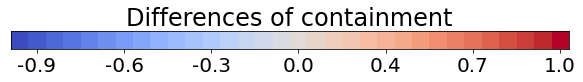

In [84]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(10, 15))
ax.imshow(np.linspace(-1,1,n_steps).reshape(1,n_steps),cmap='coolwarm')
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(-1,1,n_steps)),1)[np.arange(0,n_steps,5)+1],
        title='Differences of containment')
plt.show()